## Programming : 
  Please write a program to demonstrate the same

In [2]:
#Necessary imports
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')
#For Preprocessing
import cv2
#Additional imports for functionality
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#For Graphing and Plotting Images
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline

#For model building
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense,Flatten,Conv2D,Activation,Dropout,MaxPool2D
from tensorflow.keras import regularizers
from tensorflow.keras import losses

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Getting foldernames from dataset
foldernames = os.listdir('/content/drive/MyDrive/NNDL_Proj/raw-img')

#Creating Empty lists for categories and the files
categories = []
files = []
i = 0

Dict = {}
names = []

#Going over all the folders and their categories in the foldernames
for k, folder in enumerate(foldernames):
    Dict[folder]=k
    names.append(folder)
    #Getting the filenames
    filenames = os.listdir("/content/drive/MyDrive/NNDL_Proj/raw-img/" + folder);
    for file in filenames:
        #Appending all the image files into one list
        files.append("/content/drive/MyDrive/NNDL_Proj/raw-img/" + folder + "/" + file)
        #Appending categories into one list
        categories.append(k)

#Defining a DataFrame to store data
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

#Taking 500 files of each category from the data into train_df
train_df = pd.DataFrame(columns=['filename', 'category'])
for i in range(10):
    train_df = train_df.append(df[df.category == i].iloc[:500,:])

print(Dict)
print(names)
#Taking a peek at the data using head()
train_df.head()
train_df = train_df.reset_index(drop=True)
train_df

{'dog': 0, 'horse': 1, 'elephant': 2, 'butterfly': 3, 'chicken': 4, 'cat': 5, 'cow': 6, 'sheep': 7, 'squirrel': 8, 'spider': 9}
['dog', 'horse', 'elephant', 'butterfly', 'chicken', 'cat', 'cow', 'sheep', 'squirrel', 'spider']


,filename,category
0,/content/drive/MyDrive/NNDL_Proj/raw-img/dog/O...,0
1,/content/drive/MyDrive/NNDL_Proj/raw-img/dog/O...,0
2,/content/drive/MyDrive/NNDL_Proj/raw-img/dog/O...,0
3,/content/drive/MyDrive/NNDL_Proj/raw-img/dog/O...,0
4,/content/drive/MyDrive/NNDL_Proj/raw-img/dog/O...,0
...,...,...
4995,/content/drive/MyDrive/NNDL_Proj/raw-img/spide...,9
4996,/content/drive/MyDrive/NNDL_Proj/raw-img/spide...,9
4997,/content/drive/MyDrive/NNDL_Proj/raw-img/spide...,9
4998,/content/drive/MyDrive/NNDL_Proj/raw-img/spide...,9


In [5]:
#Assigning x and y to be the values and their target labels respectively
x = train_df['filename']
y = train_df['category']

#Shuffling the data
x, y = shuffle(x, y, random_state=8)

In [6]:
# #Standard DataPreprocessing from OpenCV used for formatting the input to fit 
# #the specifications of the input of the VGG-16 model

# images = []

# #Going over all the filenames in train_df
# for i,file_path in enumerate(train_df.filename.values):
#     #Read image using imread
#     img = cv2.imread(file_path)

#     #Converting colour channels of all pictures to RGB
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     #Centering all the images
#     img = cv2.resize(img, dsize=(256, 256))
#     # #We have to shape the output to 224x224px because the VGG-16 model takes in input shape of 224x224px 
#     # img = img[16:240, 16:240]
#     images.append(img)

# images = np.array(images)

In [7]:
# np.save('/content/drive/MyDrive/NNDL_Proj/images.npy',images)

In [8]:
images = np.load('/content/drive/MyDrive/NNDL_Proj/images.npy')

In [9]:
#Getting a list of the number of images used and a random index permutation from the data
#to randomly append images into x_shuffle along with their labels
data_num = len(y)
random_index = np.random.permutation(data_num)

#Empty lists to store shuffled data
x_shuffle = []
y_shuffle = []
for i in range(data_num):
    x_shuffle.append(images[random_index[i]])
    y_shuffle.append(y[random_index[i]])
    
x = np.array(x_shuffle) 
y = np.array(y_shuffle)

#Partitioning 20% of the dataset into test set
test_split_num = int(round(0.2*len(y)))
x_train = x[test_split_num:]
y_train = y[test_split_num:]
x_test = x[:test_split_num]
y_test = y[:test_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

#Converting categories into binary matrix of 0s and 1s where 1 represents the correct class
#and 0s in all other places
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#Converting all pixel values to float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#Formatting all the pixel values to be in between 0 and 1
x_train /= 255
x_test /= 255

#Changing category labels from given language into english
name_animal = []
for i in range(10):
    path = train_df[train_df.category == i].values[2]
    if path[0].split('/')[-2] == 'squirrel':
        name_animal.append('squirrel')
    elif path[0].split('/')[-2] == 'horse':
        name_animal.append('horse')
    elif path[0].split('/')[-2] == 'butterfly':
        name_animal.append('butterfly')
    elif path[0].split('/')[-2] == 'cow':
        name_animal.append('cow')
    elif path[0].split('/')[-2] == 'cat':
        name_animal.append('cat')
    elif path[0].split('/')[-2] == 'sheep':
        name_animal.append('sheep')
    elif path[0].split('/')[-2] == 'chicken':
        name_animal.append('chicken')
    elif path[0].split('/')[-2] == 'elephant':
        name_animal.append('elephant')
    elif path[0].split('/')[-2] == 'spider':
        name_animal.append('spider')
    elif path[0].split('/')[-2] == 'dog':
        name_animal.append('dog')

x_train (4000, 256, 256, 3)
y_train (4000,)
x_test (1000, 256, 256, 3)
y_test (1000,)


In [10]:
cnn_model = Sequential([Conv2D(64, (3, 3),activation = "relu", input_shape = (256,256,3),kernel_regularizer=regularizers.l2(0.01)),
                        MaxPool2D(pool_size=(2,2),strides=(2,2)),
                        Dropout(0.2),
                        Conv2D(128, (3, 3), activation = "relu",kernel_regularizer=regularizers.l2(0.01)),
                        MaxPool2D(pool_size=(2,2),strides=(2,2)),
                        Dropout(0.3),
                        Conv2D(256, (3, 3), activation = "relu",kernel_regularizer=regularizers.l2(0.01)),
                        MaxPool2D(pool_size=(2,2),strides=(2,2)),
                        Dropout(0.4),
                        ])

cnn_model.add(Flatten())
cnn_model.add(Dense(256,activation='relu'))
cnn_model.add(Dense(10, activation = 'Softmax'))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 128)       0

In [ ]:
cnn_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

history = cnn_model.fit(x_train, y_train, shuffle = True, epochs=20, batch_size = 16,
                    validation_data=(x_test, y_test))

Epoch 1/20
250/250 [==============================] - 65s 215ms/step - loss: 0.7300 - accuracy: 0.0985 - val_loss: 0.3685 - val_accuracy: 0.0930
Epoch 2/20
250/250 [==============================] - 50s 201ms/step - loss: 0.3456 - accuracy: 0.1015 - val_loss: 0.3337 - val_accuracy: 0.0890
Epoch 3/20
 83/250 [========>.....................] - ETA: 31s - loss: 0.3319 - accuracy: 0.1069

CNN: Epochs=75, Train accuracy=0.94175, Validation accuracy=0.88200


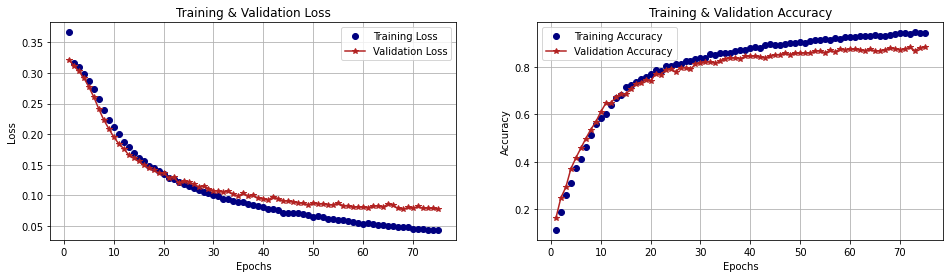

In [ ]:
print("CNN: Epochs={0:d}, Train accuracy={1:.5f}, Validation accuracy={2:.5f}".format(epochs,history.history['accuracy'][epochs-1],history.history['val_accuracy'][epochs-1]))

#Function to plot Graphs
def show_plots(history):
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['accuracy'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    #Plotting Graph for the Losses
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', linestyle=' ', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    #Plot Graph for the Accuracies
    acc_vals = history['accuracy']
    val_acc_vals = history['val_accuracy']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', ls=' ', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
show_plots(history.history)

In [ ]:
from tensorflow.keras.models import load_model
filename = "/content/drive/MyDrive/NNDL_Proj/batch_32.h5"
model = load_model(filename)

In [ ]:
#Getting test labels and predictions
preds = np.round(model.predict(x_test),0)
categorical_test_labels = pd.DataFrame(y_test).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)

In [ ]:
confusion_matrix = confusion_matrix(categorical_test_labels, categorical_preds)

In [ ]:
#Function to Plot Confusion Matrix
def plot_confusion_matrix(cm, classes,
             title='Confusion matrix',
             cmap=plt.cm.Blues):
    #Normalize the values
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Confusion matrix')
    
    #Plot the matrix
    plt.figure(figsize=[12,12])
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    
    #Going over all ten categories, and for each category going over all 
    #ten categories to get a square matrix for every category 
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.3f'), horizontalalignment="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix


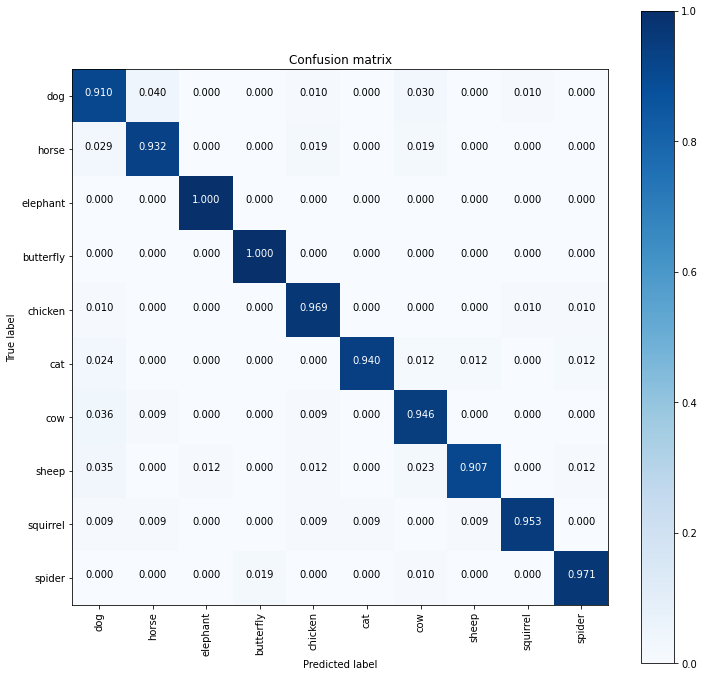

In [ ]:
#Call plotting function
plot_confusion_matrix(confusion_matrix, names)